# 7.0 Image Augmentation (Albumentation) in Computer Vision

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import os
import gc
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import joblib 
from tqdm import tqdm
import warnings
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
#(!pip install iterative-stratification)

In [3]:
rcParams['figure.figsize'] = (8, 4)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
import pretrainedmodels
# https://github.com/Cadene/pretrained-models.pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [59]:
# https://albumentations.ai/docs/getting_started/image_augmentation/
# https://hoya012.github.io/blog/albumentation_tutorial/
import albumentations as A
from albumentations.pytorch import ToTensor

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, 
    ElasticTransform, ChannelShuffle,RGBShift, Rotate, Cutout
)

In [6]:
!ls ../input/

class_map.csv		   test_image_data_3.parquet
class_map_corrected.csv    train.csv
df_folds.csv		   train_image_data_0.parquet
sample_submission.csv	   train_image_data_1.parquet
test.csv		   train_image_data_2.parquet
test_image_data_0.parquet  train_image_data_3.parquet
test_image_data_1.parquet  train_images
test_image_data_2.parquet  train_multi_diacritics.csv


In [7]:
# YOUR PATH
path = f'/mnt/c/Users/bokhy/Desktop/Python/github/kaggle/bengaliai-cv19/input/'

### 7.1 Experimentation

#### 7.1.1 Bring a single image

In [10]:
img = joblib.load(os.path.join(path, f'train_images/Train_419.pkl'))
img = img.reshape(137, 236).astype(np.uint8)
img = 255 - img
img = img[:, : , np.newaxis]

In [11]:
# It's one-dimensional image
img.shape

(137, 236, 1)

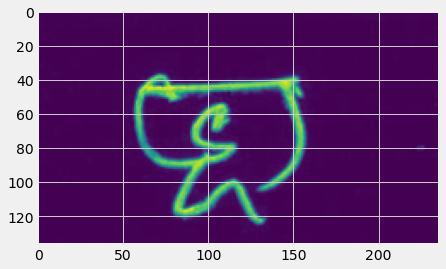

In [18]:
plt.imshow(img)

In [19]:
# Repeat the image dimension
# This means we repeat the image 3 times in 3 dimension (0,1,2,3..)
img = np.repeat(img, 3, 2)

In [22]:
# Now it's three-dimensional image
img.shape

(137, 236, 3)

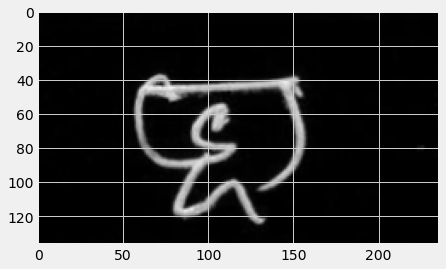

In [20]:
plt.imshow(img)

#### 7.1.2 Use Image Augmentation using Albumentation

In [60]:
train_transforms = Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
        ToTensor()
    ], p=1.0)

In [61]:
img = joblib.load(os.path.join(path, f'train_images/Train_419.pkl'))
img = img.reshape(137, 236).astype(np.uint8)
img = 255 - img
img = img[:, : , np.newaxis]

In [62]:
img = train_transforms(image = img)['image']

In [63]:
img

tensor([[[0.0824, 0.0824, 0.0784,  ..., 0.0863, 0.0863, 0.0863],
         [0.0824, 0.0863, 0.0824,  ..., 0.0902, 0.0902, 0.0863],
         [0.0784, 0.0784, 0.0784,  ..., 0.0902, 0.0902, 0.0863],
         ...,
         [0.0824, 0.0784, 0.0784,  ..., 0.0745, 0.0745, 0.0784],
         [0.0745, 0.0745, 0.0745,  ..., 0.0784, 0.0784, 0.0784],
         [0.0745, 0.0745, 0.0745,  ..., 0.0824, 0.0784, 0.0784]]])

### 7.2 Add Albumentation Tranformation to The Pytorch Class

In [64]:
class BengaliDataset(Dataset):
    
    # Add 'transform'
    def __init__(self, csv, img_height, img_width, transform):
        self.csv = csv.reset_index()
        self.img_ids = csv['image_id'].values
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = joblib.load(os.path.join(path, f'train_images/{img_id}.pkl'))
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = 255 - img
        img = img[:, : , np.newaxis]
        
        # Repeat the image dimension
        # This means we repeat the image 3 times in 3 dimension (0,1,2,3..)
        img = np.repeat(img, 3, 2)
        
        if self.transform is not None:
            img = self.transform(image = img)['image']
        
        label_1 = self.csv.iloc[index].grapheme_root
        lable_2 = self.csv.iloc[index].vowel_diacritic
        lable_3 = self.csv.iloc[index].consonant_diacritic
        
        # Unlike last time, we do not have to manually convert the image result to Pytorch
        # because in Albumentation, we defined it to be Pytorch Tensor. So just return itself
        return img, label_1, label_2, label_3

In [65]:
# Please refer to '03_Pytoch_dataset_creation_training_validation.ipynb'
index = 0
HEIGHT = 137
WIDTH = 236

df_train = pd.read_csv(os.path.join(path, 'train.csv'))
df_train['fold'] = pd.read_csv(os.path.join(path, 'df_folds.csv'))['fold']

trn_fold = [i for i in range(6) if i not in [5]]
vld_fold = [5]

trn_idx = df_train.loc[df_train['fold'].isin(trn_fold)].index
vld_idx = df_train.loc[df_train['fold'].isin(vld_fold)].index

label_1 = df_train.iloc[index].grapheme_root
label_2 = df_train.iloc[index].vowel_diacritic
label_3 = df_train.iloc[index].consonant_diacritic

In [66]:
# We let the augmentation to happen at the moment of training job (from initial image creation),
# instead of augmentation in batches

trn_dataset = BengaliDataset(csv = df_train.loc[trn_idx],
                            img_height = HEIGHT,
                            img_width = WIDTH,
                            transform = train_transforms) # Add Albumentation Transform

In [67]:
trn_dataset[0]

(tensor([[[0.0118, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0039],
          [0.0078, 0.0078, 0.0039,  ..., 0.0078, 0.0039, 0.0000],
          [0.0118, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0039, 0.0039],
          [0.0118, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          [0.0118, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0118, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0039],
          [0.0078, 0.0078, 0.0039,  ..., 0.0078, 0.0039, 0.0000],
          [0.0118, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0039, 0.0039],
          [0.0118, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          [0.0118, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0118, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0039],
          [0.0078, 0.0078, 0.0039,  ..., 0.0078, 0.0039, 0.0000],
          [0.0118, 0.0078, 0.0039,  ...,

In [68]:
trn_dataset[0][0]

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0078,  ..., 0.0000, 0.0078, 0.0118],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
         [0.0078, 0.0078, 0.0039,  ..., 0.0039, 0.0078, 0.0078],
         [0.0157, 0.0118, 0.0118,  ..., 0.0078, 0.0118, 0.0157]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0078,  ..., 0.0000, 0.0078, 0.0118],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
         [0.0078, 0.0078, 0.0039,  ..., 0.0039, 0.0078, 0.0078],
         [0.0157, 0.0118, 0.0118,  ..., 0.0078, 0.0118, 0.0157]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0078,  ..., 0.0000, 0.0078, 0.

In [69]:
trn_dataset[0][0].shape

torch.Size([3, 137, 236])

#### Each time you run below cell, it will output different image, with the albumentation

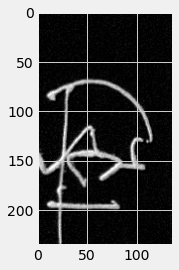

In [79]:
plt.imshow(trn_dataset[0][0].permute(1,2,0))